In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import warnings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
# Load the dataset
df = pd.read_csv('Mall_Customers.csv')  # Make sure the file is in your working directory

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())

Dataset Shape: (200, 5)

First 5 rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
No

In [ ]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


In [ ]:
# Preprocess the data
# Selecting only the numerical columns from the dataset
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[features]

# Standardize the data
scaler = StandardScaler() #z=x-mean/std
X_scaled = scaler.fit_transform(X) #setting mean to zero and std to 1

print("Original data shape:", X.shape)
print("Scaled data shape:", X_scaled.shape)
print("\nFirst 5 rows of scaled data:")
print(X_scaled[:5])

Original data shape: (200, 3)
Scaled data shape: (200, 3)

First 5 rows of scaled data:
[[-1.42456879 -1.73899919 -0.43480148]
 [-1.28103541 -1.73899919  1.19570407]
 [-1.3528021  -1.70082976 -1.71591298]
 [-1.13750203 -1.70082976  1.04041783]
 [-0.56336851 -1.66266033 -0.39597992]]


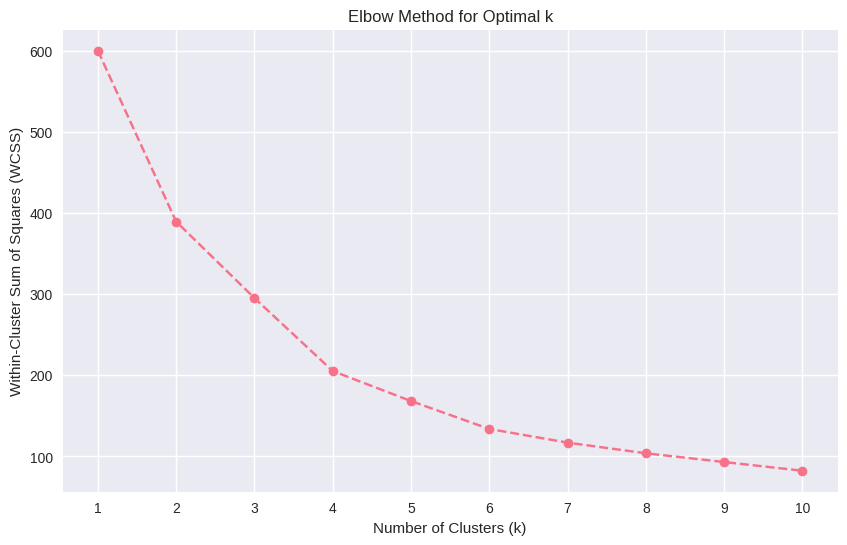

In [ ]:
# 2. K-Means - Elbow Method to find optimal k
# Calculate WCSS for different k values
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
# Based on elbow method, let's choose k=5
optimal_k = 5
#Loading the Kmeans Data
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_kmeans = df.copy()
df_kmeans['Cluster'] = kmeans_labels

# Calculate silhouette score
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")
print(f"Number of clusters: {optimal_k}")

K-Means Silhouette Score: 0.417
Number of clusters: 5


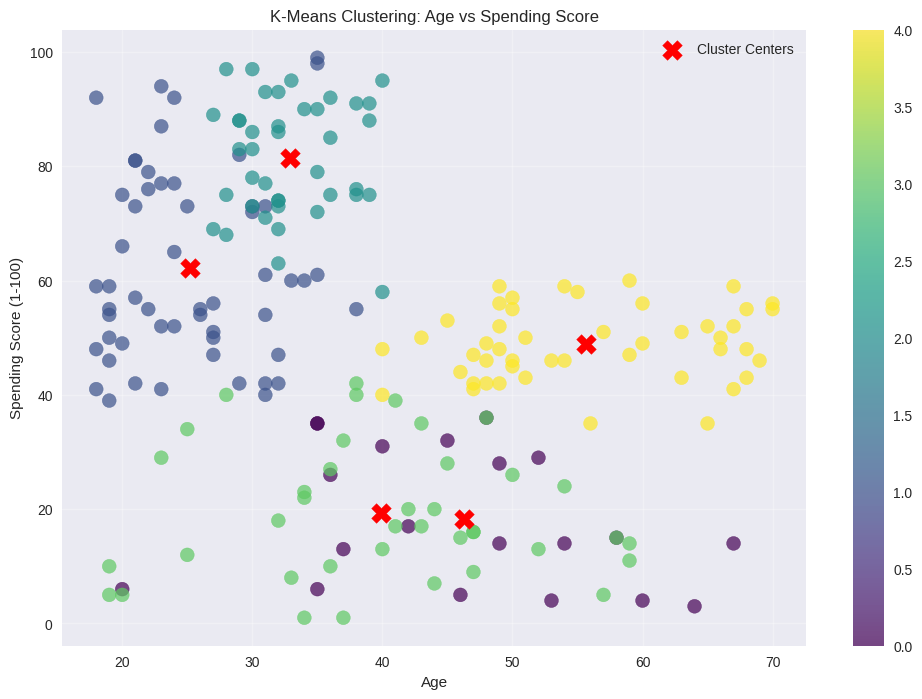

In [ ]:
# Visualize K-Means clusters using a 2D scatter plot (Age vs Spending Score)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Age'], df['Spending Score (1-100)'],
                     c=kmeans_labels, cmap='viridis', s=100, alpha=0.7)
plt.colorbar(scatter)
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.title('K-Means Clustering: Age vs Spending Score')
plt.grid(True, alpha=0.3)

# Add cluster centers (in original scale)
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers_original[:, 0], centers_original[:, 2],
           marker='X', s=200, c='red', label='Cluster Centers')
plt.legend()
plt.show()

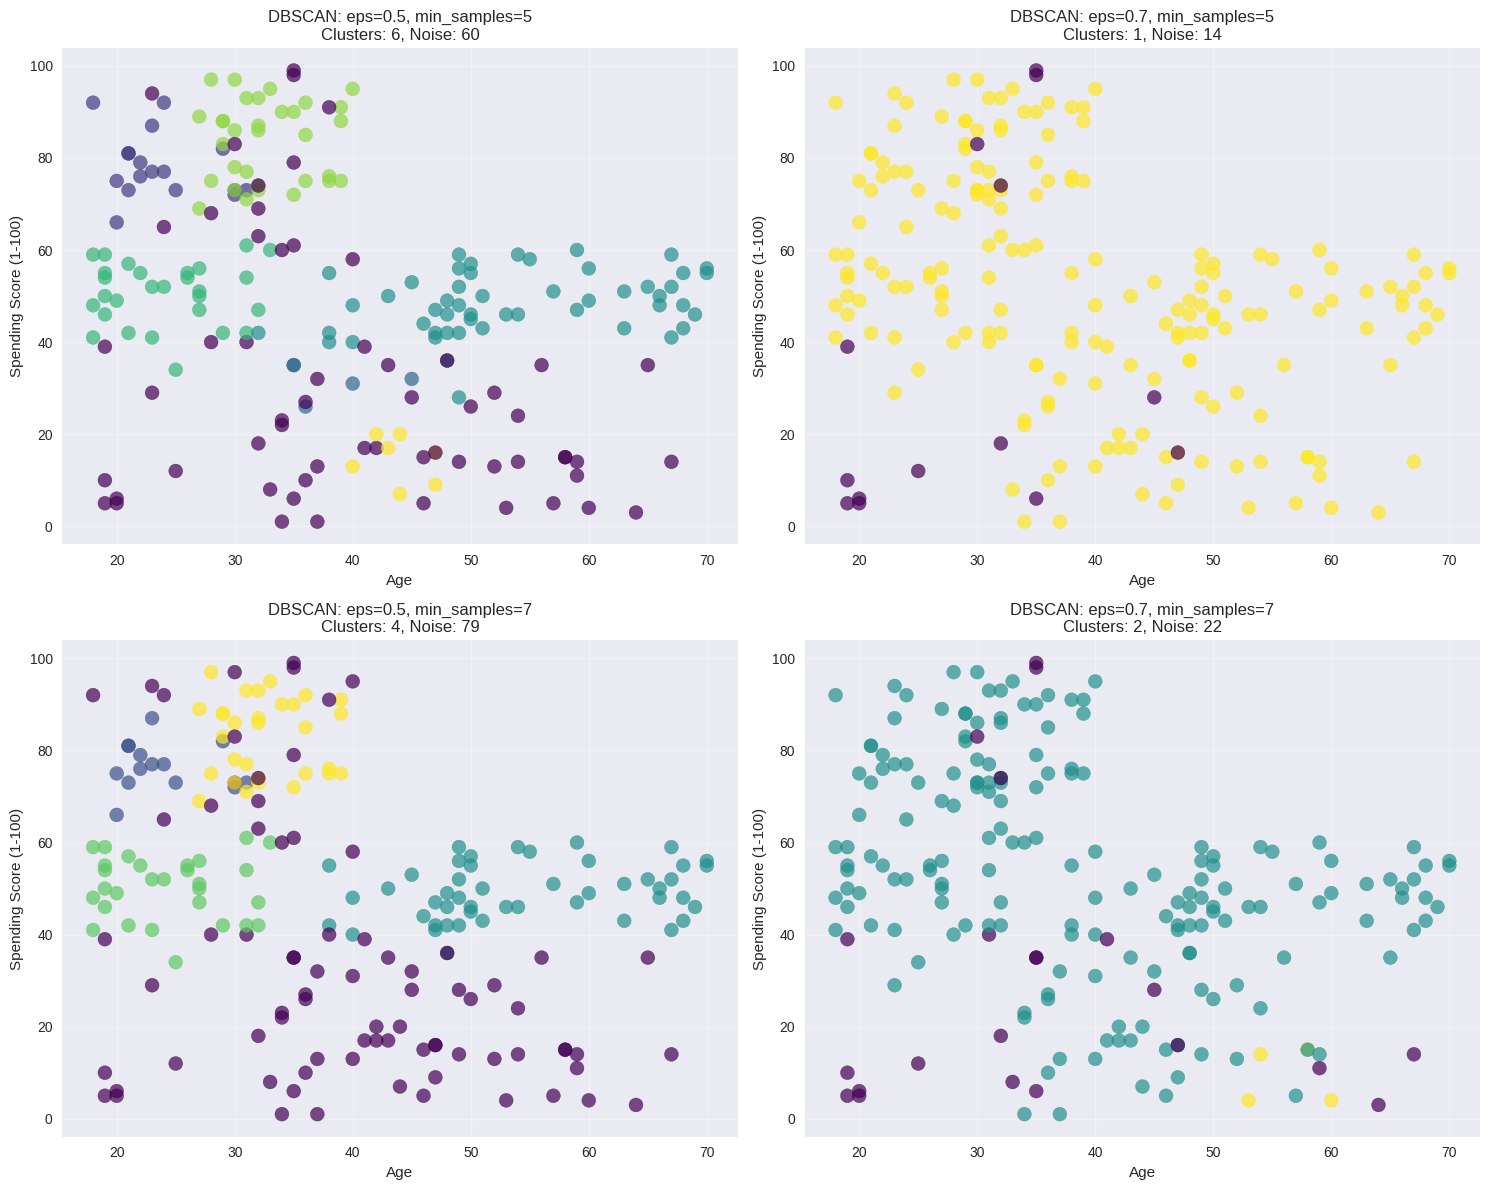

In [ ]:
# DBSCAN Clustering - Parameter tuning
# Let's try different combinations of eps and min_samples
dbscan_results = []

# Parameter ranges to try
eps_values = [0.3, 0.5, 0.7, 0.9]
min_samples_values = [3, 5, 7, 10]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (eps, min_samples) in enumerate([(0.5, 5), (0.7, 5), (0.5, 7), (0.7, 7)]):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X_scaled)

    # Count clusters (excluding noise points labeled as -1)
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)

    # Calculate silhouette score (excluding noise)
    if len(set(dbscan_labels)) > 1 and -1 in dbscan_labels:
        # Filter out noise points for silhouette score
        mask = dbscan_labels != -1
        if len(set(dbscan_labels[mask])) > 1:
            dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        else:
            dbscan_silhouette = -1
    elif len(set(dbscan_labels)) > 1:
        dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels)
    else:
        dbscan_silhouette = -1

    # Store results
    dbscan_results.append({
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette_score': dbscan_silhouette
    })

    # Plot
    scatter = axes[i].scatter(df['Age'], df['Spending Score (1-100)'],
                             c=dbscan_labels, cmap='viridis', s=100, alpha=0.7)
    axes[i].set_title(f'DBSCAN: eps={eps}, min_samples={min_samples}\n'
                     f'Clusters: {n_clusters}, Noise: {n_noise}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Spending Score (1-100)')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Final DBSCAN with best parameters
# Based on the plots, choose the best parameters
best_eps = 0.5
best_min_samples = 5

dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan_final.fit_predict(X_scaled)

# Add to dataframe
df_dbscan = df.copy()
df_dbscan['Cluster'] = dbscan_labels

# Calculate metrics
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

# Silhouette score (excluding noise)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if len(set(dbscan_labels[mask])) > 1:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    else:
        dbscan_silhouette = -1
else:
    dbscan_silhouette = -1

print(f"DBSCAN Results:")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")
print(f"Silhouette Score: {dbscan_silhouette:.3f}")

DBSCAN Results:
Number of clusters: 6
Number of noise points: 60
Silhouette Score: 0.482


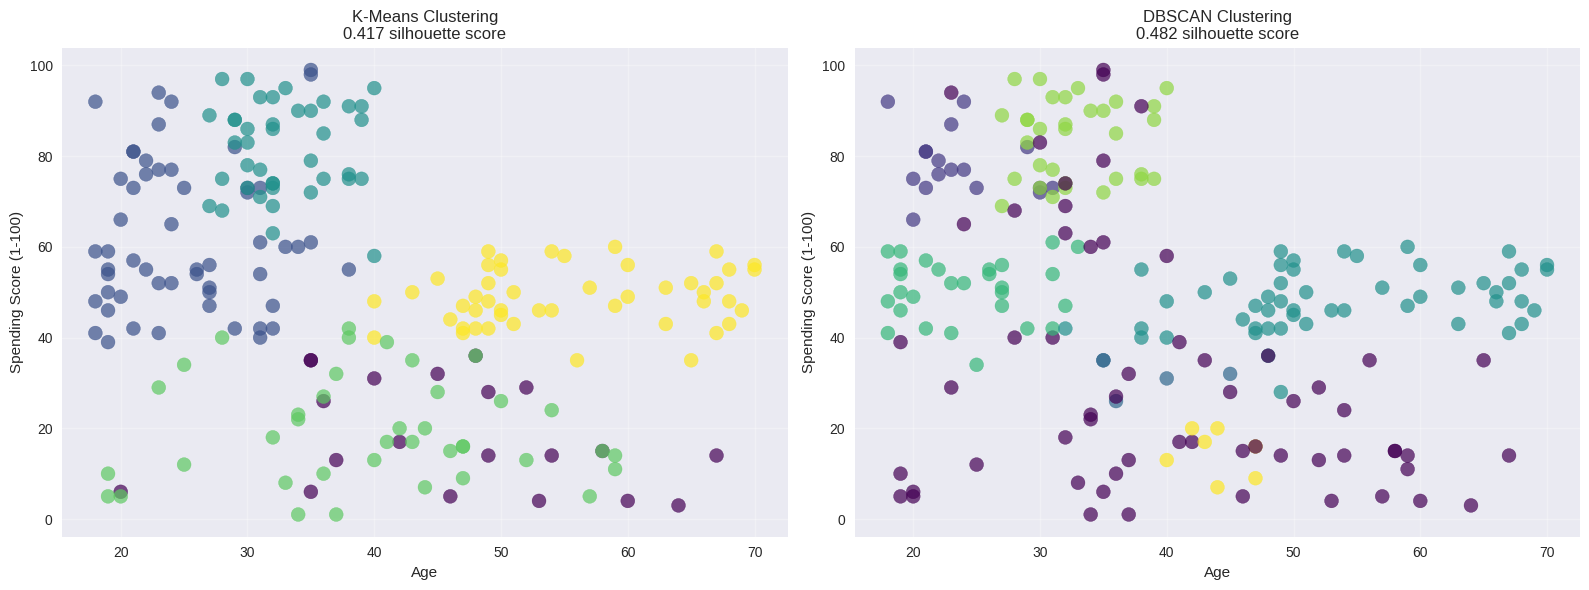

In [ ]:
# Additional visualizations and insights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-Means visualization
scatter1 = ax1.scatter(df['Age'], df['Spending Score (1-100)'],
                      c=kmeans_labels, cmap='viridis', s=100, alpha=0.7)
ax1.set_title(f'K-Means Clustering\n{kmeans_silhouette:.3f} silhouette score')
ax1.set_xlabel('Age')
ax1.set_ylabel('Spending Score (1-100)')
ax1.grid(True, alpha=0.3)

# DBSCAN visualization
scatter2 = ax2.scatter(df['Age'], df['Spending Score (1-100)'],
                      c=dbscan_labels, cmap='viridis', s=100, alpha=0.7)
ax2.set_title(f'DBSCAN Clustering\n{dbscan_silhouette:.3f} silhouette score')
ax2.set_xlabel('Age')
ax2.set_ylabel('Spending Score (1-100)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Cluster analysis and interpretation
print("K-MEANS CLUSTER ANALYSIS")
print("="*30)
cluster_stats = df_kmeans.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Annual Income (k$)': ['mean', 'std'],
    'Spending Score (1-100)': ['mean', 'std'],
    'CustomerID': 'count'
}).round(2)

print(cluster_stats)
print("\n")

print("DBSCAN CLUSTER ANALYSIS")
print("="*30)
if n_clusters_dbscan > 0:
    dbscan_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster').agg({
        'Age': ['mean', 'std'],
        'Annual Income (k$)': ['mean', 'std'],
        'Spending Score (1-100)': ['mean', 'std'],
        'CustomerID': 'count'
    }).round(2)
    print(dbscan_stats)

    print(f"\nNoise points (Cluster -1): {n_noise}")
    if n_noise > 0:
        noise_stats = df_dbscan[df_dbscan['Cluster'] == -1][features].describe()
        print("\nNoise points statistics:")
        print(noise_stats)

K-MEANS CLUSTER ANALYSIS
           Age        Annual Income (k$)        Spending Score (1-100)         \
          mean    std               mean    std                   mean    std   
Cluster                                                                         
0        46.25  11.58              26.75   7.31                  18.35  11.94   
1        25.19   5.51              41.09  16.82                  62.24  16.60   
2        32.88   3.86              86.10  16.34                  81.53  10.00   
3        39.87  10.94              86.10  16.73                  19.36  11.61   
4        55.64   8.91              54.38   8.82                  48.85   6.30   

        CustomerID  
             count  
Cluster             
0               20  
1               54  
2               40  
3               39  
4               47  


DBSCAN CLUSTER ANALYSIS
           Age       Annual Income (k$)       Spending Score (1-100)        \
          mean   std               mean   std         

In [ ]:
# Compare Results Summary Section
results = []

# Example: If you used KMeans
if 'kmeans' in locals():
    kmeans_clusters = len(set(kmeans.labels_))
    kmeans_silhouette = silhouette_score(X_scaled, kmeans.labels_)
    results.append({
        'Algorithm': 'K-Means',
        'No. of Clusters': kmeans_clusters,
        'Silhouette Score': round(kmeans_silhouette, 3),
        'Observations': 'Balanced cluster distribution' if kmeans_clusters > 2 else 'Few large clusters'
    })

# Example: If you used Hierarchical Clustering
if 'hierarchical_labels' in locals():
    hier_clusters = len(set(hierarchical_labels))
    hier_silhouette = silhouette_score(X_scaled, hierarchical_labels)
    results.append({
        'Algorithm': 'Hierarchical Clustering',
        'No. of Clusters': hier_clusters,
        'Silhouette Score': round(hier_silhouette, 3),
        'Observations': 'Better cluster cohesion than K-Means' if hier_silhouette > 0.5 else 'Overlapping clusters'
    })

# Use the results from the final DBSCAN model (from cell 81-I4ye9DaxK)
if 'dbscan_final' in locals() and 'dbscan_labels' in locals() and 'dbscan_silhouette' in locals() and 'n_clusters_dbscan' in locals():
    results.append({
        'Algorithm': 'DBSCAN',
        'No. of Clusters': n_clusters_dbscan,
        'Silhouette Score': round(dbscan_silhouette, 3) if n_clusters_dbscan > 1 else 'N/A',
        'Observations': 'Good noise detection' if n_clusters_dbscan > 1 else 'Too sensitive to parameters'
    })

# Create summary table
comparison_df = pd.DataFrame(results)

print("=== Clustering Results Summary ===")
display(comparison_df)

=== Clustering Results Summary ===


,Algorithm,No. of Clusters,Silhouette Score,Observations
0,K-Means,5,0.417,Balanced cluster distribution
1,DBSCAN,6,0.482,Good noise detection
